In [ ]:
# # 1. 기본 라이브러리 불러오기
# import torch
# import torch.nn as nn # 신경망(Neural Network)을 구성하는 모듈
# import torch.nn.functional as F # 신경망 모델의 활성화 함수(Activation Function)를 정의하는 모듈

# import torchvision
# import torchvision.transforms as transforms # 이미지 데이터를 조작하는 모듈
# from torchsummary import summary # 모델의 구조를 요약하여 출력하는 모듈

# import matplotlib.pyplot as plt # 시각화를 위한 라이브러리

# # GPU 사용 가능 여부 확인
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # CUDA
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # MPS
# print("✅ Using device:", device)

✅ Using device: mps


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

root = './'
if not os.path.exists(root):
    os.makedirs(root)

Using cpu device


In [ ]:
# settings for data normalization
trans = transforms.ToTensor()
# trans = transforms.Compose([transform.ToTensor(), transform.Normalize((0.5,),(1.0,))]) # x-u(뮤)/6(표준편차) 순서대로 각각 0.5, 1.0
# trans = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()])

# (DL Process) 1. Data Load
train_data = datasets.FashionMNIST(
    root='./dataset',
    train=True,
    download=True,
    transform=trans,
)

test_data = datasets.FashionMNIST(
    root='./dataset',
    train=False,
    download=True,
    transform=trans,
)


batch_size = 50

train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [ ]:
# (DL Process) 2. Network 구성 (CNN)
# two convolution layers followed by two linear layers

class MyConvNet(nn.Module):   # nn.Module should be inherited for the neural network configuration so that it can work with backpropagation APIs
    def __init__(self):    # define layers: two conv layers and two linear (fully connected) layers
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), # 1 input channel, 32 filters, 5x5 kernel -> Output: 24x24x32 (30-3+1)
            nn.BatchNorm2d(32), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 2x2 max-pooling -> Output: 12x12x32

            nn.Conv2d(32, 64, 3, padding=1), # 32 input channels, 64 filters, 5x5 kernel -> Output: 12x12x64 (14-3+1)
            nn.BatchNorm2d(64), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 2x2 max-pooling -> Output: 6x6x64

            nn.Conv2d(64, 128, 3, padding=1), # 64 input channels, 128 filters, 3x3 kernel -> Output: 6x6x128 (8-3+1)
            nn.BatchNorm2d(128), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 2x2 max-pooling -> Output: 3x3x128

            nn.Flatten(), # flatten the output of the previous layer -> Output: 512x1
            nn.Dropout(0.5), # Dropout layer
            nn.Linear(3*3*128, 512), # Weights: 512x1024, Bias: 512x1
            nn.ReLU(),
            nn.Linear(512, 10) #  Weights: 10x512, Bias: 10x1
        )

    # network connection: two conv layers, each followed by relu and max-pooling with (2x2) kernel, and two linear layer
    def forward(self, x):
        logits = self.conv_layers(x) # forward propagation
        return(logits) # return the output of the network


# generate neural net model
model = MyConvNet().to(device) # CPU or GPU
print(model)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4222378888.py, line 21)

In [ ]:
# (DL Process) 3. Optimizer/Loss Function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [15]:
# (DL Process) 4. Model Training & Test

# epoch: 10
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(10):
    # training phase
    model.train() # 모델을 학습 모드로 전환
    current_loss= 0.0

    # train_loader: 데이터 로더에서 데이터를 가져옴
    for batch_num, (x, target) in enumerate(train_loader):
        x, target = x.to(device), target.to(device) # 학습을 위해 데이터를 디바이스에 올림

        out = model(x) # 모델에 데이터를 넣어 예측값을 얻음
        loss = criterion(out,target) # 예측값과 실제값의 차이를 계산 (Losss)

        optimizer.zero_grad() # 모델의 가중치를 초기화
        loss.backward() # Loss Back Propagation
        optimizer.step() # Weight Update
        current_loss += loss # Loss 값을 누적

        # Display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100)) # 100개의 배치마다 현재 에폭과 배치 번호, 현재 손실 값을 출력
            current_loss = 0.0 # 누적된 Loss 값을 초기화


    # test phase
    with torch.no_grad(): # 테스트 단계에서는 가중치 업데이트가 필요하지 않으므로 가중치 업데이트를 비활성화
        model.eval() # 모델을 평가 모드로 전환
        total_samples = 0.0 # 전체 샘플 수를 초기화
        correct_samples = 0.0 # 정확하게 분류된 샘플 수를 초기화

        for (x, target) in test_loader: # 테스트 데이터 로더에서 데이터를 가져옴
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1) # 예측값 중 가장 높은 값을 가진 클래스를 선택
            correct_samples += (pred == target).sum() # 정확하게 분류된 샘플 수를 누적 (sum 함수는 텐서의 모든 요소의 합을 계산)
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))

epoch: 0, batch_num: 100, current_loss: 2.294
epoch: 0, batch_num: 200, current_loss: 2.286
epoch: 0, batch_num: 300, current_loss: 2.279
epoch: 0, batch_num: 400, current_loss: 2.272
epoch: 0, batch_num: 500, current_loss: 2.260
epoch: 0, batch_num: 600, current_loss: 2.249
epoch: 0, batch_num: 700, current_loss: 2.235
epoch: 0, batch_num: 800, current_loss: 2.219
epoch: 0, batch_num: 900, current_loss: 2.198
epoch: 0, batch_num: 1000, current_loss: 2.175
epoch: 0, batch_num: 1100, current_loss: 2.142
epoch: 0, batch_num: 1200, current_loss: 2.107
Accuracy: 39.910
epoch: 1, batch_num: 100, current_loss: 2.060
epoch: 1, batch_num: 200, current_loss: 2.002
epoch: 1, batch_num: 300, current_loss: 1.933
epoch: 1, batch_num: 400, current_loss: 1.836
epoch: 1, batch_num: 500, current_loss: 1.731
epoch: 1, batch_num: 600, current_loss: 1.624
epoch: 1, batch_num: 700, current_loss: 1.515
epoch: 1, batch_num: 800, current_loss: 1.412
epoch: 1, batch_num: 900, current_loss: 1.313
epoch: 1, batc

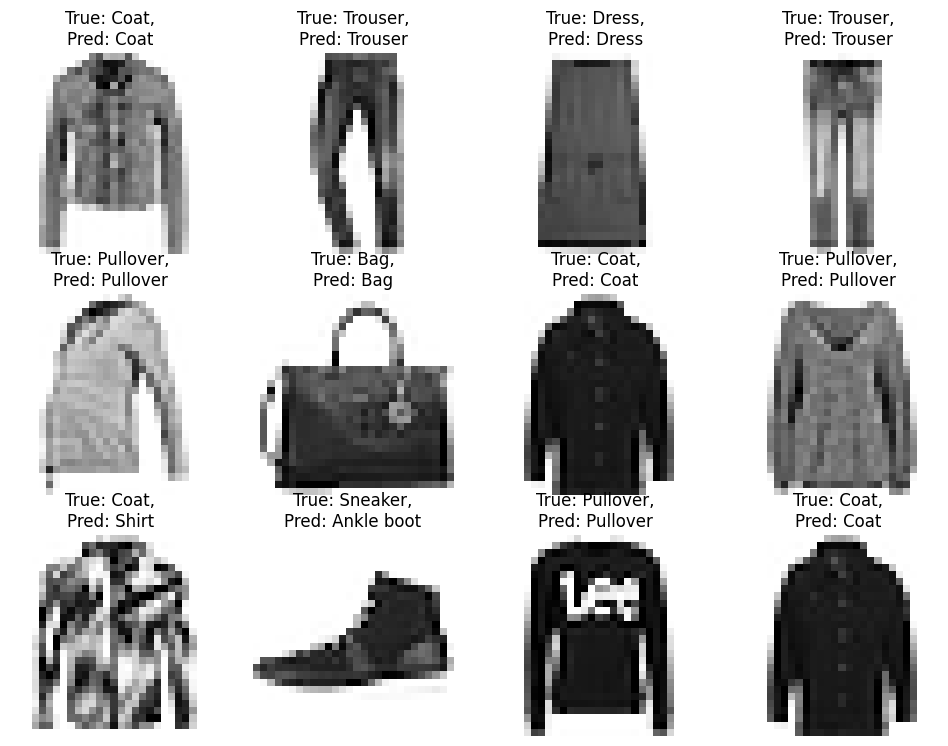

In [16]:
# Display Some test results
import numpy as np
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# take one batch of the data (Batch_size = 50)
test_data, test_labels = next(iter(test_loader))

# if cuda_available:
test_data, test_labels = test_data.to(device), test_labels.to(device) # move the data to GPU
out = model(test_data)              # put the test data to the trained network
pred = torch.argmax(out,1)          # prediction to the highest probability


sample_index = np.random.choice(batch_size, size=12)     # take 12 random sample index
num_samples = sample_index.size     # number of samples

random_samples = test_data[sample_index].cpu().numpy() # get the test data

plt.figure(figsize=(12, 12)) # set the figure size

# display test samples
for k in range(num_samples):
    plt.subplot(4, 4, k + 1)
    plt.imshow(random_samples[k].reshape(28, 28),cmap='Greys')
    plt.title("True: " + str( classes[test_labels[sample_index[k]].item()]) + ",\nPred: " + str(classes[pred[sample_index[k]].item()]))
    plt.axis('off')


plt.show()

In [17]:
# save model
torch.save(model, root + 'CNN_Fashion_MNIST.pth')

# load model
# model = torch.load('my_CNN_model.pth')

In [ ]:
# # save model weights
# torch.save(model.state_dict(), 'model_weights.pth')

# # load model weights
# model = MyConvNet()
# model.load_state_dict(torch.load('model_weights.pth'))